In [1]:
import sys
MODULE_DIR = "/workspaces/bartesian"

if MODULE_DIR not in sys.path:
    sys.path.append(MODULE_DIR)

In [2]:
import os
from glob import glob
from pathlib import Path
import numpy as np

from bartesian.barcodes import (
    barcode_to_widths,
    normalize_barcodes,
    draw_barcode,
)
from bartesian.datasheet import load_data, review_datasheet
from bartesian.enums import Drink
from bartesian.ml import create_model, train_model, create_training_data

2024-02-10 21:43:12.517346: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-10 21:43:12.570049: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 21:43:12.570099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 21:43:12.571438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-10 21:43:12.581045: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-10 21:43:12.582373: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
IMAGE_DIR = Path("/workspaces/bartesian/images/raw_images")
CROPPED_IMAGE_DIR = Path("/workspaces/bartesian/images/cropped_images")
RESIZED_IMAGE_DIR = Path("/workspaces/bartesian/images/resized_images")

isolate_barcodes(IMAGE_DIR, CROPPED_IMAGE_DIR)

while True:
    response = input("Deleted all invalid barcodes? (y/n)").lower()
    if response == "n":
        raise Exception("Please delete all invalid barcodes before continuing")
    if response == "y":
        break

TARGET_BARCODE_RESOLUTION = (1024, 530)
resize_barcodes(
    CROPPED_IMAGE_DIR,
    RESIZED_IMAGE_DIR,
    resolution=TARGET_BARCODE_RESOLUTION
)

In [4]:

# Process each barcode image in the directory
barcode_widths_dict: dict[str, list[int]] = {}
barcodes = glob(os.path.join(RESIZED_IMAGE_DIR, '*'))
for barcode_image in barcodes:
    widths = barcode_to_widths(barcode_image)
    barcode_widths_dict[barcode_image] = widths

# barcode_widths_dict now contains the representation of each barcode


13


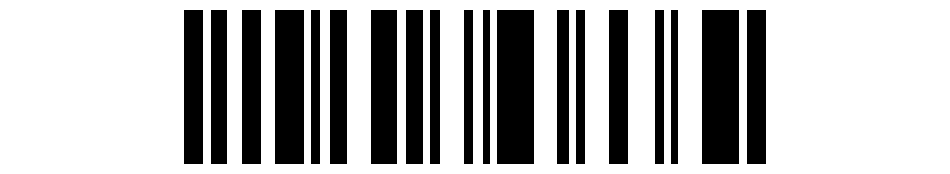

In [5]:
for vocab_size in range(13,14):
    test_size = normalize_barcodes(
        barcode_widths_dict,
        vocabulary_size=vocab_size
    )
    print(vocab_size)
    draw_barcode(
        test_size["barcodes"]["/workspaces/bartesian/images/resized_images/0[PXL_20240121_013857214.MP].jpg"],
        test_size["thickness"],
        .3
    )

In [6]:
all_record_json = load_data()
all_records = {i["drink"]: i for i in all_record_json}
records = {i["drink"]: i for i in all_record_json if i["image"]}

In [7]:
review_datasheet(all_record_json)

Missing Images:
  - Drink.AMARETTO_SOUR
  - Drink.AVIATION
  - Drink.BLOOD_AND_SAND
  - Drink.CANDYMAN_MARGARITA
  - Drink.CLAUSMOPOLITAN
  - Drink.CUPIDS_ARROW
  - Drink.DIRTY_VODKA_MARTINI
  - Drink.GINGER_PEACH_ICED_TEA
  - Drink.GINGERBREAD_COOKIE_MARTINI
  - Drink.GREAT_GATSBY
  - Drink.HEMINGWAY_DAIQUIRI
  - Drink.HOLIDAY_SPICED_OLD_FASHIONED
  - Drink.HURRICANE
  - Drink.JALAPEÑO_LIME_SHRUB
  - Drink.JUNGLE_BIRD
  - Drink.KAMIKAZE
  - Drink.LONG_ISLAND_ICED_TEA
  - Drink.LOW_CAL_COSMOPOLITAN
  - Drink.LOW_CAL_MARGARITA
  - Drink.LOW_CAL_OLD_FASHIONED
  - Drink.LOW_CAL_WHISKEY_SOUR
  - Drink.MAI_TAI
  - Drink.MARGARITA
  - Drink.MISTLETOE_MARGARITA
  - Drink.MRS_CLAUSS_NIGHTCAP
  - Drink.NEGRONI
  - Drink.NORTHSIDE
  - Drink.PAINKILLER
  - Drink.PAPER_PLANE
  - Drink.PEARY_CHRISTMAS
  - Drink.PENICILLIN
  - Drink.PEPPERMINT_PATTY_MARTINI
  - Drink.PINEAPPLE_SAGE_VODKA_STILL
  - Drink.POMEGRANATE_MARGARITA
  - Drink.RASPBERRY_GINGER_GIMLET
  - Drink.RUM_BREEZE
  - Drink.RUM_RUNNER

In [8]:
drink_to_filename: dict[Drink, str] = {
    Drink.SEX_ON_THE_BEACH: 'PXL_20240121_013747782.jpg',
    Drink.PASSION_FRUIT_MARGARITA: 'PXL_20240121_013803629.MP.jpg',
    Drink.COSMOPOLITAN: 'PXL_20240121_013815977.MP.jpg',
    Drink.BEES_KNEES: 'PXL_20240121_013832187.MP.jpg',
    Drink.PINEAPPLE_MARGARITA: 'PXL_20240121_013842468.MP.jpg',
    Drink.ESPRESSO_MARTINI: 'PXL_20240121_013850719.MP.jpg',
    Drink.WHISKEY_SOUR: 'PXL_20240121_013857214.MP.jpg',
    Drink.SIDECAR: 'PXL_20240121_013909370.jpg',
    Drink.BLACKBERRY_MARGARITA: 'PXL_20240121_184839130.jpg',
    Drink.APPLE_PIE: 'PXL_20240121_013724688.jpg',
    Drink.LEMON_DROP: 'PXL_20240121_184849045.jpg',
    Drink.MANHATTAN: 'PXL_20240121_013733706.MP.jpg',
    Drink.OLD_FASHIONED: 'PXL_20240121_184912979.jpg',
}

file_name_to_drink = {v:k for k,v in drink_to_filename.items()}

In [9]:
barcode_results = normalize_barcodes(
    barcode_widths_dict,
    vocabulary_size=13
)

In [10]:
training_data = create_training_data(
    barcodes=barcode_results["barcodes"],
    file_name_to_drink=file_name_to_drink,
    data=records,
)

strengths: set[float] = set()
for v in records.values():
    for strength in STRENGTH_ORDER:
        strengths.add(v[strength])

strength_categories = dict(zip(range(len(strengths)), sorted(strengths)))
rev_strength_categories = {v:k for k,v in strength_categories.items()}

In [11]:
EPOCHS = 20
INPUT_SIZE = 37

In [12]:
model = create_model(INPUT_SIZE)

In [13]:
train_model(model, training_data, EPOCHS)

Training for fold 1 ...
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.8249
Epoch 2/20
1/1 [==============================] - 0s 13ms/step - loss: 0.6989
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6723
Epoch 4/20
1/1 [==============================] - 0s 16ms/step - loss: 0.6512
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6445
Epoch 6/20
1/1 [==============================] - 0s 13ms/step - loss: 0.6175
Epoch 7/20
1/1 [==============================] - 0s 12ms/step - loss: 0.6444
Epoch 8/20
1/1 [==============================] - 0s 16ms/step - loss: 0.6443
Epoch 9/20
1/1 [==============================] - 0s 15ms/step - loss: 0.6299
Epoch 10/20
1/1 [==============================] - 0s 13ms/step - loss: 0.6358
Epoch 11/20
1/1 [==============================] - 0s 16ms/step - loss: 0.6300
Epoch 12/20
1/1 [==============================] - 0s 18ms/step - loss: 0.6261
Epoch 13/20
1/1 [======================

In [14]:

# To make a prediction:
prediction = model.predict(np.array([training_data[0]["input"]]))
predicted_matrix = prediction.reshape(5, 4)

print(training_data[0]['filename'].replace("0-", ""))
# print(output_to_continuous(predicted_matrix, strength_categories))
print(np.around(predicted_matrix, decimals=1))

1/1 [==============================] - 0s 183ms/step
/workspaces/bartesian/images/resized_images/0[PXL_20240121_013815977.MP].jpg
[[0.  0.  0.  0. ]
 [0.  1.  1.  1. ]
 [0.  0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]
